In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['the-simpsons-characters-dataset', 'glove-global-vectors-for-word-representation', 'imdb-raw']


In [7]:
imdb_dir = '../input/imdb-raw/aclimdb/aclImdb'
train_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

Using TensorFlow backend.


In [10]:
maxlen = 100 # Cuts off reviews after 100 words
training_samples = 200 # Trains on 200 samples
validation_samples = 10000 # Validates on 10,000 samples
max_words = 10000 # Considers only the top 10,000 words in the dataset

In [11]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [12]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 72633 unique tokens.


In [13]:
data = pad_sequences(sequences, maxlen=maxlen)

In [14]:
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (17243, 100)
Shape of label tensor: (17243,)


### Splits the data into a training set and a validation set, but first shuffles the data, because you’re starting with data in which samples are ordered (all negative first, then all positive) 

In [15]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [16]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

### Let’s parse the unzipped file (a .txt file) to build an index that maps words (as strings) to their vector representation (as number vectors).

In [17]:
glove_dir = '../input/glove-global-vectors-for-word-representation/'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [18]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector #Words not found in the embedding index will be all zeros. 

In [19]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [21]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 2.0746 - acc: 0.7000 - val_loss: 0.6833 - val_acc: 0.7244
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4531 - acc: 0.7750 - val_loss: 1.0860 - val_acc: 0.7244
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3959 - acc: 0.8450 - val_loss: 0.6250 - val_acc: 0.7239
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3352 - acc: 0.9050 - val_loss: 0.8351 - val_acc: 0.7242
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1592 - acc: 0.9750 - val_loss: 0.8935 - val_acc: 0.7242
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2097 - acc: 0.9000 - val_loss: 0.6472 - val_acc: 0.7215
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0736 - acc: 1.0000 - val_loss: 0.7396 - val_acc: 0.7244
Epoch 8/10
200/200 [========

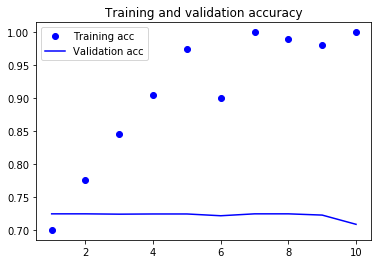

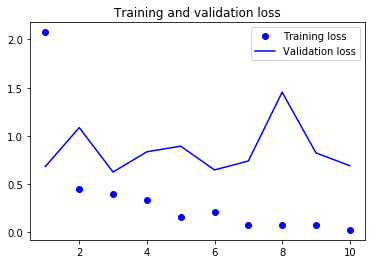

In [22]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

###  You can also train the same model without loading the pretrained word embeddings and without freezing the embedding layer. In that case, you’ll learn a taskspecific embedding of the input tokens, which is generally more powerful than pretrained word embeddings when lots of data is available. But in this case, you have only 200 training samples. Let’s try it.

In [23]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.6572 - acc: 0.7050 - val_loss: 0.6054 - val_acc: 0.7244
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3771 - a

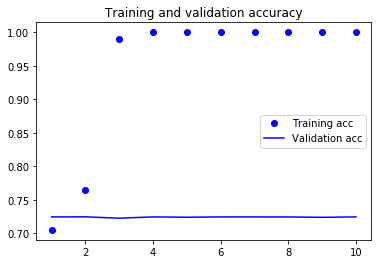

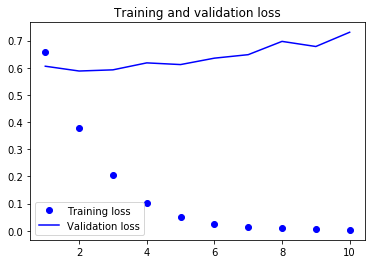

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()